In [142]:
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pypfopt as ppo
import sqlite3
import os
import holidays

In [143]:
ibov_close = pd.read_csv('./data/ativos_ibov/ivob_close.csv')

threshold = len(ibov_close)
ibov_close.dropna(thresh=threshold, axis=1, inplace=True)

ibov_close['Date'] = pd.to_datetime(ibov_close['Date'])

ibov_close.set_index('Date', inplace=True)
ibov_close = ibov_close.loc['2010-01-01':'2019-12-31']
returns = ibov_close.pct_change().dropna()

In [144]:
# Portfolio simples com rp
port = rp.Portfolio(returns=returns)

method_mu = 'hist'    # Method to estimate expected returns based on historical data.
method_cov = 'hist'   # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Convert the covariance matrix to a positive definite matrix
port.cov = rp.cov_fix(port.cov, method='nearest', threshold=1e-08)

# Estimate optimal portfolio:
model = 'Classic'     # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV'             # Risk measure used, this time will be variance
obj = 'MinRisk'       # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True           # Use historical scenarios for risk measures that depend on scenarios
rf = 0                # Risk free rate
l = 0                 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
weights,3.673246e-09,1.327060e-08,1.909319e-08,0.100554,0.038285,4.355883e-09,0.18039,6.088589e-09,2.280720e-09,6.407689e-08,...,4.543654e-09,1.361298e-08,2.910673e-09,3.834077e-09,0.001925,0.198061,4.363208e-09,0.010311,0.176858,0.176522


In [ ]:
    # Raise an error if the covariance matrix is None
    if port.cov is None:
        raise ValueError("Covariance matrix is None")
    else:
        # Convert the covariance matrix to a positive definite matrix
        port.cov = rp.cov_fix(port.cov, method='nearest', threshold=1e-08)

In [166]:
brazil_holidays = holidays.Brazil()

weights_df = pd.DataFrame()

# Loop through each month and calculate the weights
for month in pd.date_range(start='2010-01-01', end='2019-12-31', freq='ME'):
    # Adjust the date to the next business day if it falls on a weekend or holiday
    if month.weekday() >= 5 or month in brazil_holidays or month.is_year_end:  # 5 = Saturday, 6 = Sunday
        month += pd.offsets.BDay(1)
    
    monthly_returns = returns.loc[:month.strftime('%Y-%m-%d')].replace([np.inf, -np.inf], np.nan).dropna()

    # Build the portfolio object
    port = rp.Portfolio(returns=monthly_returns)

    # Calculate optimal portfolio
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Check if the covariance matrix is positive definite
    if not rp.AuxFunctions.is_pos_def(port.cov):
        print(f"Matrix is not positive definite at {month}")
        port.cov = rp.cov_fix(port.cov, method='clipped', threshold=1e-08)
    
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    
    # Store the weights in the dataframe
    w = w.T
    w['Date'] = month
    w.set_index('Date', inplace=True)
    weights_df = pd.concat([weights_df, w])

# Reindex the weights dataframe to match the index of the returns dataframe and fill missing values with the previous ones
weights_df = weights_df.reindex(returns.index, method='ffill').dropna()

# Display the reindexed weights dataframe
weights_df

You must convert self.cov to a positive definite matrix
Matrix is not positive definite at 2010-02-01 00:00:00


,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,1.056121e-09,3.971361e-08,9.556494e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145580e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430613e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
2010-02-02,1.056121e-09,3.971361e-08,9.556494e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145580e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430613e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
2010-02-03,1.056121e-09,3.971361e-08,9.556494e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145580e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430613e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
2010-02-04,1.056121e-09,3.971361e-08,9.556494e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145580e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430613e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
2010-02-05,1.056121e-09,3.971361e-08,9.556494e-10,0.204788,0.007414,9.587438e-02,0.014610,7.145580e-07,1.334580e-09,3.726159e-09,...,1.421840e-09,1.184108e-08,1.454744e-01,3.430613e-09,4.911648e-09,0.252579,7.415840e-10,1.677759e-09,0.276127,0.002131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,3.504961e-09,1.259007e-08,1.799684e-08,0.099994,0.038634,4.125696e-09,0.180467,5.705478e-09,2.177532e-09,7.119612e-08,...,4.333652e-09,1.264948e-08,2.760178e-09,3.639910e-09,2.031178e-03,0.197591,4.143296e-09,1.001956e-02,0.177046,0.177633
2019-12-23,3.504961e-09,1.259007e-08,1.799684e-08,0.099994,0.038634,4.125696e-09,0.180467,5.705478e-09,2.177532e-09,7.119612e-08,...,4.333652e-09,1.264948e-08,2.760178e-09,3.639910e-09,2.031178e-03,0.197591,4.143296e-09,1.001956e-02,0.177046,0.177633
2019-12-26,3.504961e-09,1.259007e-08,1.799684e-08,0.099994,0.038634,4.125696e-09,0.180467,5.705478e-09,2.177532e-09,7.119612e-08,...,4.333652e-09,1.264948e-08,2.760178e-09,3.639910e-09,2.031178e-03,0.197591,4.143296e-09,1.001956e-02,0.177046,0.177633


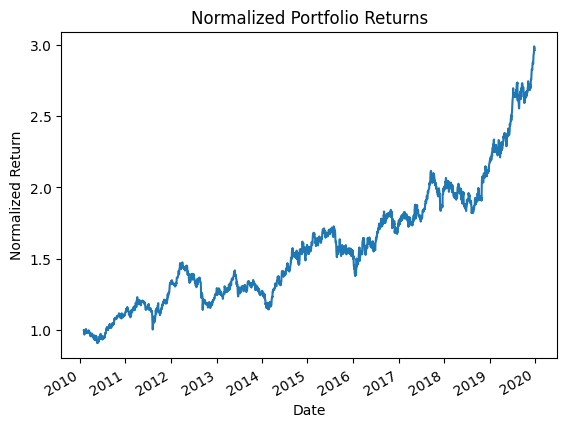

In [146]:
# Filter returns to have the same dates as weights_df
filtered_returns = returns.loc[weights_df.index]

# Calculate the portfolio returns - nx1 vector
portfolio_returns = (filtered_returns * weights_df).sum(axis=1)

# Normalize the portfolio returns to start at 1
normalized_portfolio_returns = (1 + portfolio_returns).cumprod()
normalized_portfolio_returns

# Plot the normalized portfolio returns
normalized_portfolio_returns.plot(title='Normalized Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [147]:
# Generate a binary array with 150 ones placed randomly
binary_array = np.zeros(len(returns.index))
binary_array[:150] = 1
np.random.shuffle(binary_array)

# Create a DataFrame to store the weights
weights_df_random = pd.DataFrame(index=returns.index, columns=returns.columns)

# Loop through each date and calculate the weights if the binary array value is 1
for date in returns.index[binary_array == 1]:
    # Get the data up to the current date
    returns_up_to_date = returns.loc[:date]
    
    # Drop rows with NaNs or infinite values
    returns_up_to_date = returns_up_to_date.replace([np.inf, -np.inf], np.nan).dropna()

    # Build the portfolio object
    port = rp.Portfolio(returns=returns_up_to_date)
    
    # Calculate optimal portfolio
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Raise an error if the covariance matrix is None
    if port.cov is None:
        raise ValueError("Covariance matrix is None")
    else:
        # Convert the covariance matrix to a positive definite matrix
        port.cov = rp.cov_fix(port.cov, method='nearest', threshold=1e-08)

    weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    
    # Store the weights in the dataframe
    weights_df_random.loc[date] = weights.T.values[0]

# Forward fill the weights to match the index of the returns dataframe and fill missing values with the previous ones
weights_df_random = weights_df_random.ffill().dropna()

# Filter returns to have the same dates as weights_df_random
filtered_returns_random = returns.loc[weights_df_random.index]

# Calculate the portfolio returns - nx1 vector
portfolio_returns_random = (filtered_returns_random * weights_df_random).sum(axis=1)

# Normalize the portfolio returns to start at 1
normalized_portfolio_returns_random = (1 + portfolio_returns_random).cumprod()

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


C:\Users\loren\AppData\Local\Temp\ipykernel_25072\1332571199.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weights_df_random = weights_df_random.ffill().dropna()


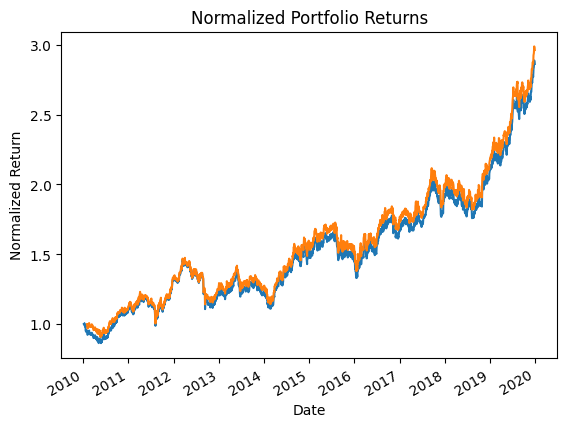

In [148]:
# Plot the normalized portfolio returns
normalized_portfolio_returns_random.plot(title='Normalized Portfolio Returns (Random Rebalancing)')
normalized_portfolio_returns.plot(title='Normalized Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [149]:
# Define the range of frequencies for rebalancing
frequencies = np.linspace(50, 400, num=10, dtype=int)

# Create a dictionary to store the normalized portfolio returns for each frequency
normalized_portfolio_returns_dict = {}

for freq in frequencies:
    # Generate a binary array with 'freq' ones placed randomly
    binary_array = np.zeros(len(returns.index))
    binary_array[:freq] = 1
    np.random.shuffle(binary_array)

    # Create a DataFrame to store the weights
    weights_df_random = pd.DataFrame(index=returns.index, columns=returns.columns)

    # Loop through each date and calculate the weights if the binary array value is 1
    for date in returns.index[binary_array == 1]:

        # Calculate returns up to the current date
        returns_up_to_date = returns.loc[:date]
        returns_up_to_date = returns_up_to_date.replace([np.inf, -np.inf], np.nan).dropna() # Drop rows with NaNs or infinite values

        # Build the portfolio object
        port = rp.Portfolio(returns=returns_up_to_date)

        # Calculate optimal portfolio
        port.assets_stats(method_mu=method_mu, method_cov=method_cov)

        # Raise an error if the covariance matrix is None
        if port.cov is None:
            raise ValueError("Covariance matrix is None")
        else:
            # Convert the covariance matrix to a positive definite matrix
            port.cov = rp.cov_fix(port.cov, method='nearest', threshold=1e-08)
            
        weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

        # Ensure weights have the correct shape
        weights = weights.T.squeeze()
        weights_df_random.loc[date] = weights

    # Forward fill the weights to match the index of the returns dataframe and fill missing values with the previous ones
    weights_df_random = weights_df_random.reindex(returns.index, method='ffill').dropna()

    # Filter returns to have the same dates as weights_df_random
    filtered_returns_random = returns.loc[weights_df_random.index]

    # Calculate the portfolio returns - nx1 vector
    portfolio_returns_random = (filtered_returns_random * weights_df_random).sum(axis=1)

    # Normalize the portfolio returns to start at 1
    normalized_portfolio_returns_random = (1 + portfolio_returns_random).cumprod()

    # Store the normalized portfolio returns in the dictionary
    normalized_portfolio_returns_dict[freq] = normalized_portfolio_returns_random

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


C:\Users\loren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\reductions\solvers\solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite

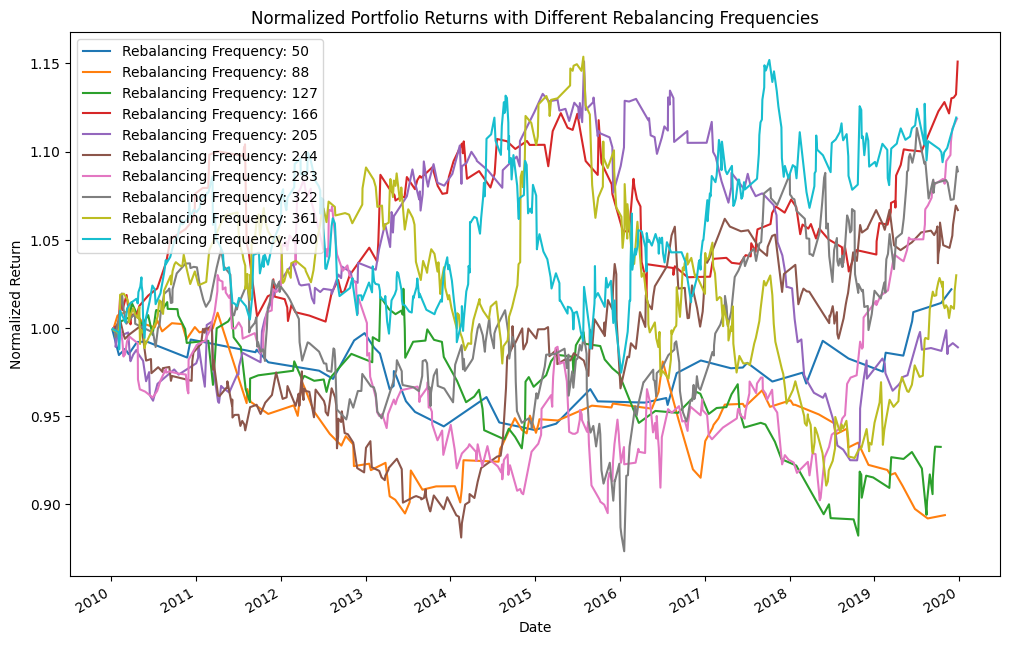

In [150]:
# Plot the normalized portfolio returns for each frequency
plt.figure(figsize=(12, 8))
for freq, normalized_returns in normalized_portfolio_returns_dict.items():
    normalized_returns.plot(label=f'Rebalancing Frequency: {freq}')

plt.title('Normalized Portfolio Returns with Different Rebalancing Frequencies')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.legend()
plt.show()